# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [46]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/NotAnnotated/Regular/NotAveragePooled/split_features_1s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [47]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [48]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [49]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [50]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [51]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [52]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2],audio_features.shape[3]), name='Audio_Features')


  features = tf.keras.layers.Conv2D(
              filters=64,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(inputs)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  # features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2')(features)


  # features = tf.keras.layers.Conv2D(
  #             filters=32,
  #             kernel_size=(5,5),
  #             strides=(1,1),
  #             padding='same',
  #             name='conv_3',
  #             activation='relu',
  #             kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  # features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.MaxPool2D(pool_size=(4,4), name='pool_3')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=256,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.5)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation='softmax')(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [53]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_1s_model_training_history_2D_annotated_2.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [54]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [55]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [56]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [57]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(42578, 128, 87, 4)


In [58]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(13083, 128, 87, 4)


In [59]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 4)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,373,812 (5.24 MB)

 Trainable params: 1,373,812 (5.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.2588 - loss: 8.2039 - weighted_accuracy: 0.2588 - val_accuracy: 0.2423 - val_loss: 4.7390 - val_weighted_accuracy: 0.2423
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.4863 - loss: 3.7745 - weighted_accuracy: 0.4863 - val_accuracy: 0.3125 - val_loss: 3.8287 - val_weighted_accuracy: 0.3125
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.5819 - loss: 2.8538 - weighted_accuracy: 0.5819 - val_accuracy: 0.2818 - val_loss: 3.5337 - val_weighted_accuracy: 0.2818
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.6362 - loss: 2.3000 - weighted_accuracy: 0.6362 - val_accuracy: 0.2930 - val_loss: 3.3117 - val_weighted_accuracy: 0.2930
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.6718 - loss: 1.9347 - weighted_accuracy: 0.6718 - val_accuracy: 0.3108 - val_loss: 3.1256 - val_weighted_accuracy: 0.3108
Epoch 6/100
1331/1331 ━━━━━━━━

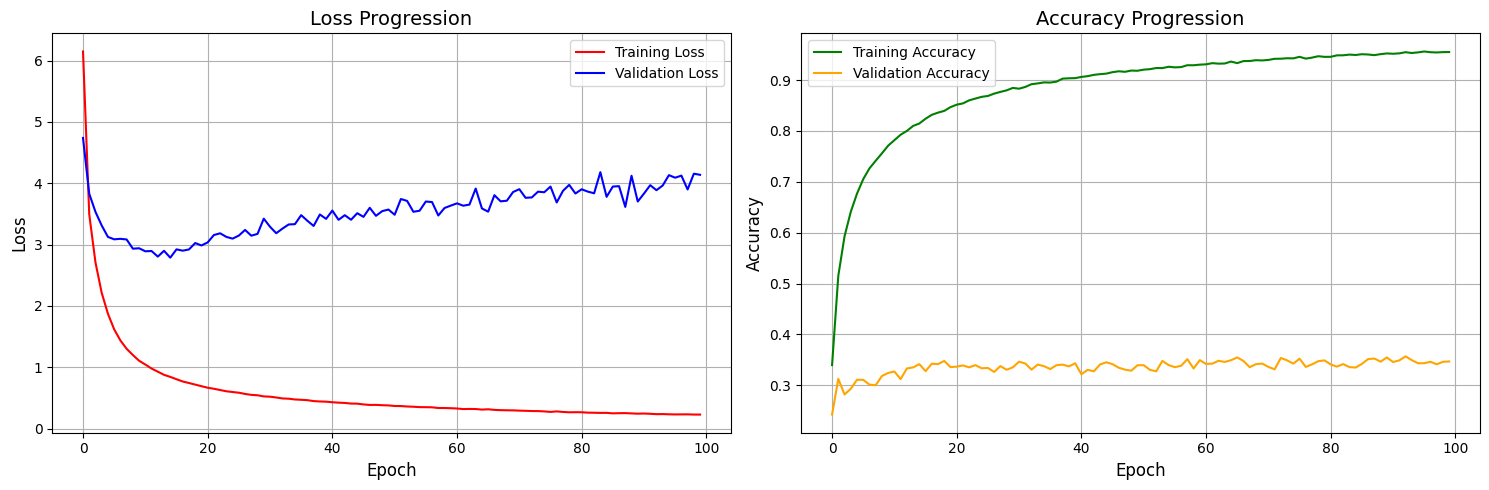

In [60]:
visualize(history, 'all_features')

In [61]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9958 - loss: 0.1163 - weighted_accuracy: 0.9958
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3394 - loss: 4.1984 - weighted_accuracy: 0.3394


In [62]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.22      0.28      0.25       793
           1       0.52      0.59      0.55      1294
           2       0.34      0.44      0.39       617
           3       0.39      0.39      0.39       984
           4       0.35      0.14      0.20       229
           5       0.01      0.00      0.01       303
           6       0.22      0.12      0.16       275
           7       0.46      0.56      0.50       698
           8       0.14      0.49      0.21       176
           9       0.65      0.41      0.50       227
          10       0.30      0.12      0.17       455
          11       0.44      0.05      0.09      1660
          12       0.39      0.37      0.38      1261
          13       0.50      0.31      0.38       502
          14       0.09      0.31      0.14       156
          15       0.42      0.62      0.50       798
          16       0.65      0.57      0.61   

### Mel Spectrogram and Chroma

In [63]:
# Train features
target_size = 128
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'],  chroma_tiled), axis=-1)
print(training_features.shape)

(42578, 128, 87, 2)


In [64]:
# Validation Features
target_size = 128
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'],  chroma_tiled), axis=-1)
print(validation_features.shape)

(13083, 128, 87, 2)


In [65]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,370,612 (5.23 MB)

 Trainable params: 1,370,612 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.1768 - loss: 6.4276 - weighted_accuracy: 0.1768 - val_accuracy: 0.2327 - val_loss: 3.1232 - val_weighted_accuracy: 0.2327
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.3430 - loss: 2.5148 - weighted_accuracy: 0.3430 - val_accuracy: 0.2603 - val_loss: 2.7239 - val_weighted_accuracy: 0.2603
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4049 - loss: 2.1496 - weighted_accuracy: 0.4049 - val_accuracy: 0.2782 - val_loss: 2.6218 - val_weighted_accuracy: 0.2782
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4479 - loss: 1.9830 - weighted_accuracy: 0.4479 - val_accuracy: 0.2837 - val_loss: 2.6861 - val_weighted_accuracy: 0.2837
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4680 - loss: 1.8820 - weighted_accuracy: 0.4680 - val_accuracy: 0.3169 - val_loss: 2.5675 - val_weighted_accuracy: 0.3169
Epoch 6/100
1331/1331 ━━━━━━━━

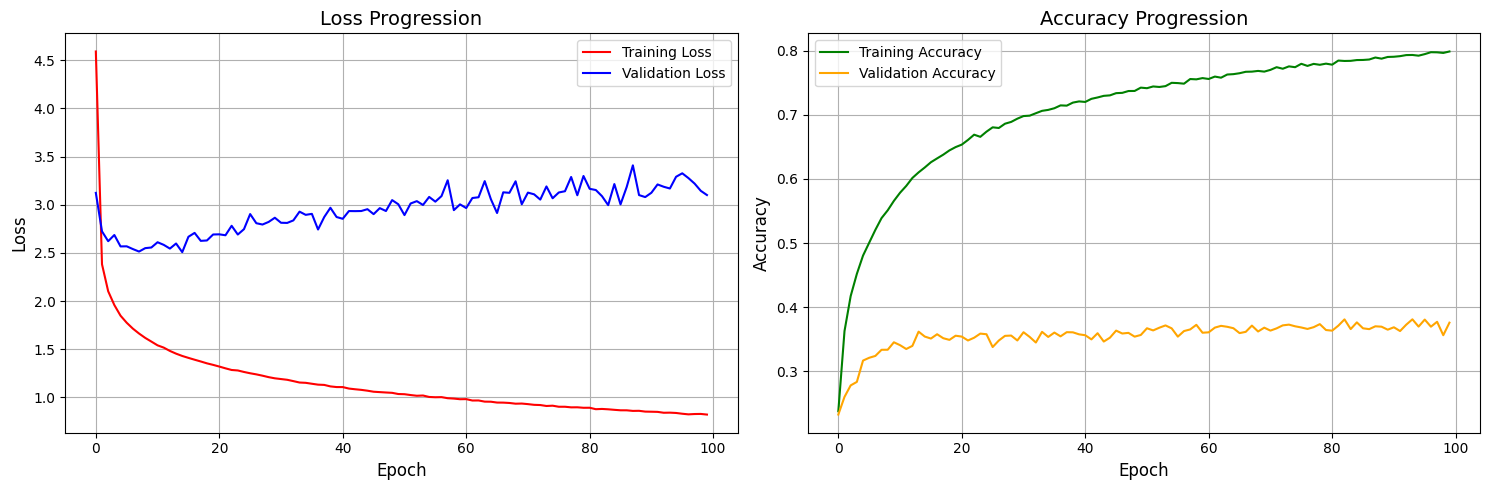

In [66]:
visualize(history, 'melspectrogram_chroma')

In [67]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8878 - loss: 0.5919 - weighted_accuracy: 0.8878
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3751 - loss: 3.1206 - weighted_accuracy: 0.3751


In [68]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.35      0.46      0.40       793
           1       0.48      0.58      0.53      1294
           2       0.41      0.49      0.45       617
           3       0.49      0.65      0.56       984
           4       0.29      0.12      0.17       229
           5       0.17      0.09      0.11       303
           6       0.10      0.08      0.09       275
           7       0.44      0.45      0.44       698
           8       0.13      0.39      0.20       176
           9       0.32      0.35      0.34       227
          10       0.27      0.18      0.22       455
          11       0.31      0.03      0.05      1660
          12       0.51      0.39      0.44      1261
          13       0.49      0.37      0.42       502
          14       0.05      0.10      0.06       156
          15       0.38      0.56      0.45       798
          16       0.50      0.73      0.59   

### With Mel Spectrogram, MFCCs and Chroma

In [69]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(42578, 128, 87, 3)


In [70]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(13083, 128, 87, 3)


In [71]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,372,212 (5.23 MB)

 Trainable params: 1,372,212 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.1866 - loss: 6.5743 - weighted_accuracy: 0.1866 - val_accuracy: 0.2421 - val_loss: 3.1763 - val_weighted_accuracy: 0.2421
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.3604 - loss: 2.5532 - weighted_accuracy: 0.3604 - val_accuracy: 0.2765 - val_loss: 2.7774 - val_weighted_accuracy: 0.2765
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.4235 - loss: 2.1373 - weighted_accuracy: 0.4235 - val_accuracy: 0.2993 - val_loss: 2.6679 - val_weighted_accuracy: 0.2993
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.4623 - loss: 1.9480 - weighted_accuracy: 0.4623 - val_accuracy: 0.2941 - val_loss: 2.6063 - val_weighted_accuracy: 0.2941
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.4911 - loss: 1.8288 - weighted_accuracy: 0.4911 - val_accuracy: 0.3138 - val_loss: 2.5867 - val_weighted_accuracy: 0.3138
Epoch 6/100
1331/1331 ━━━━━━━━

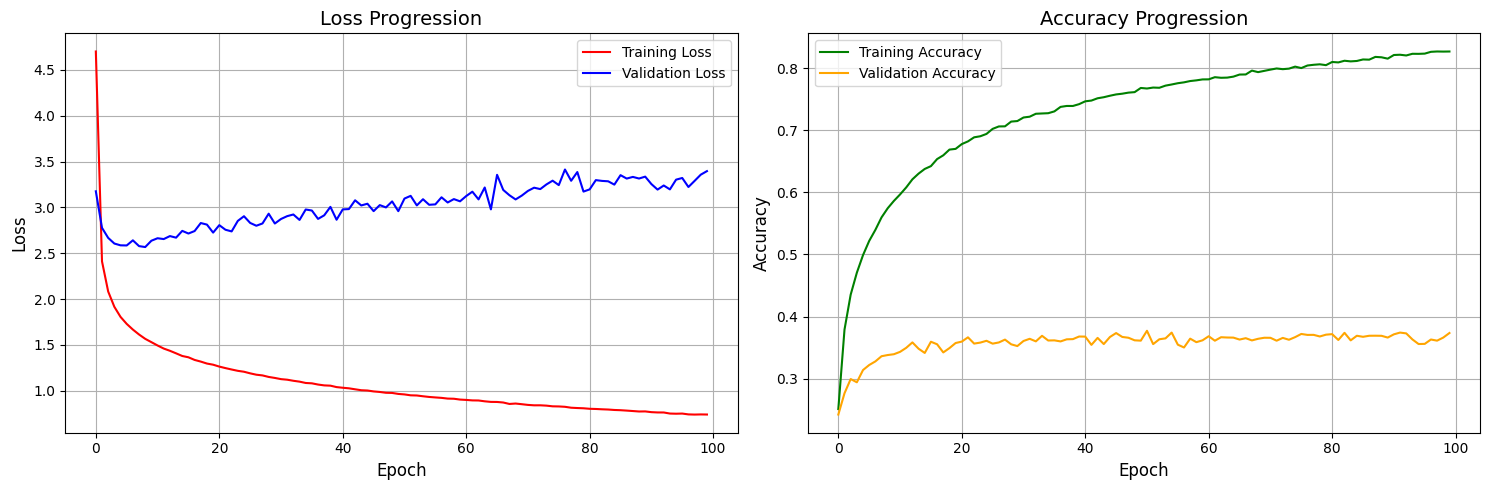

In [72]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [73]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9004 - loss: 0.5367 - weighted_accuracy: 0.9004
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3766 - loss: 3.4030 - weighted_accuracy: 0.3766


In [74]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.33      0.46      0.39       793
           1       0.45      0.59      0.51      1294
           2       0.45      0.43      0.44       617
           3       0.38      0.69      0.49       984
           4       0.26      0.17      0.21       229
           5       0.19      0.12      0.15       303
           6       0.09      0.04      0.06       275
           7       0.48      0.43      0.45       698
           8       0.14      0.27      0.18       176
           9       0.36      0.37      0.37       227
          10       0.28      0.20      0.23       455
          11       0.32      0.01      0.02      1660
          12       0.40      0.46      0.42      1261
          13       0.45      0.21      0.28       502
          14       0.05      0.13      0.08       156
          15       0.37      0.56      0.45       798
          16       0.51      0.75      0.61   

### With Mel Spectrogram and MFCCs

In [75]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled), axis=-1)
print(training_features.shape)

(42578, 128, 87, 2)


In [76]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled), axis=-1)
print(validation_features.shape)

(13083, 128, 87, 2)


In [77]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,370,612 (5.23 MB)

 Trainable params: 1,370,612 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.1527 - loss: 6.3822 - weighted_accuracy: 0.1527 - val_accuracy: 0.1844 - val_loss: 3.1296 - val_weighted_accuracy: 0.1844
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2598 - loss: 2.6632 - weighted_accuracy: 0.2598 - val_accuracy: 0.2168 - val_loss: 2.8181 - val_weighted_accuracy: 0.2168
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.3225 - loss: 2.3631 - weighted_accuracy: 0.3225 - val_accuracy: 0.2525 - val_loss: 2.7121 - val_weighted_accuracy: 0.2525
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.3665 - loss: 2.2063 - weighted_accuracy: 0.3665 - val_accuracy: 0.2797 - val_loss: 2.5545 - val_weighted_accuracy: 0.2797
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.4066 - loss: 2.0823 - weighted_accuracy: 0.4066 - val_accuracy: 0.2939 - val_loss: 2.5056 - val_weighted_accuracy: 0.2939
Epoch 6/100
1331/1331 ━━━━━━━━

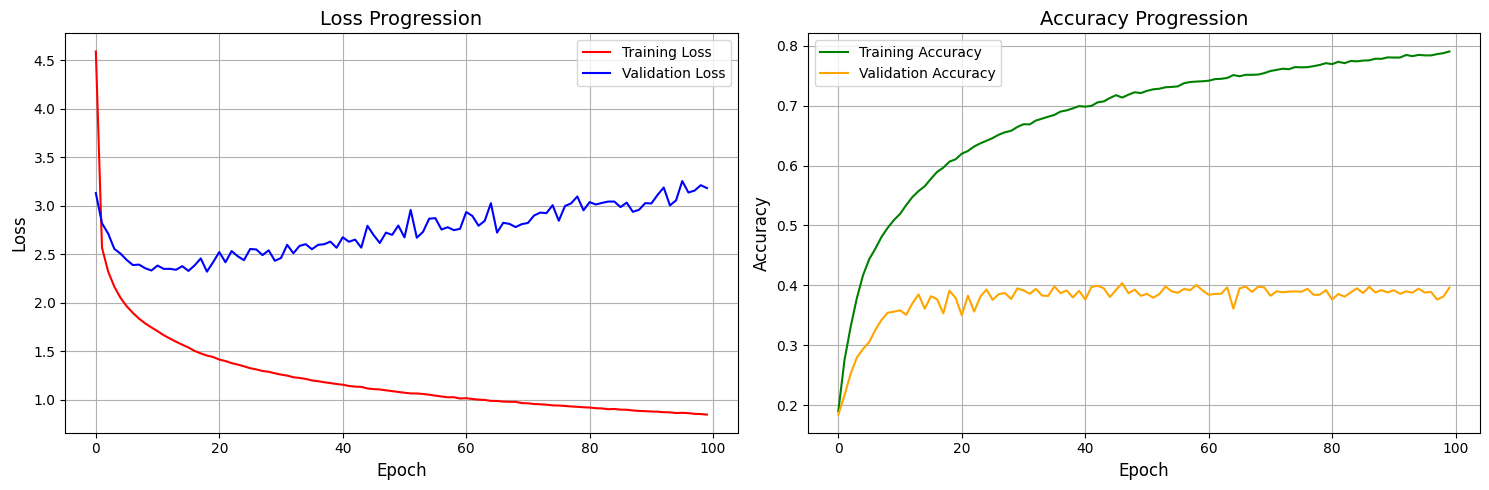

In [78]:
visualize(history, 'mfcc_melspectrogram')

In [79]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8736 - loss: 0.6129 - weighted_accuracy: 0.8736
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3973 - loss: 3.1823 - weighted_accuracy: 0.3973


In [80]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.33      0.50      0.40       793
           1       0.42      0.60      0.50      1294
           2       0.43      0.51      0.46       617
           3       0.42      0.63      0.50       984
           4       0.27      0.12      0.17       229
           5       0.08      0.04      0.05       303
           6       0.24      0.09      0.13       275
           7       0.41      0.48      0.44       698
           8       0.30      0.41      0.35       176
           9       0.42      0.42      0.42       227
          10       0.36      0.40      0.38       455
          11       0.32      0.02      0.04      1660
          12       0.43      0.45      0.44      1261
          13       0.55      0.34      0.42       502
          14       0.07      0.23      0.11       156
          15       0.49      0.50      0.50       798
          16       0.60      0.78      0.68   

### With Mel Spectrogram

In [81]:
# Train features
target_size = 128

training_features = np.expand_dims(train_features['melspectrogram'], axis=-1)
print(training_features.shape)

(42578, 128, 87, 1)


In [82]:
# Validation Features
target_size = 128
validation_features = np.expand_dims(val_features['melspectrogram'], axis=-1)
print(validation_features.shape)

(13083, 128, 87, 1)


In [83]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,369,012 (5.22 MB)

 Trainable params: 1,369,012 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.1550 - loss: 6.1236 - weighted_accuracy: 0.1550 - val_accuracy: 0.1749 - val_loss: 2.9315 - val_weighted_accuracy: 0.1749
Epoch 2/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.3114 - loss: 2.4793 - weighted_accuracy: 0.3114 - val_accuracy: 0.2755 - val_loss: 2.6215 - val_weighted_accuracy: 0.2755
Epoch 3/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.3802 - loss: 2.2056 - weighted_accuracy: 0.3802 - val_accuracy: 0.3064 - val_loss: 2.5124 - val_weighted_accuracy: 0.3064
Epoch 4/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.4176 - loss: 2.0683 - weighted_accuracy: 0.4176 - val_accuracy: 0.3054 - val_loss: 2.4832 - val_weighted_accuracy: 0.3054
Epoch 5/100
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.4459 - loss: 1.9648 - weighted_accuracy: 0.4459 - val_accuracy: 0.2988 - val_loss: 2.4865 - val_weighted_accuracy: 0.2988
Epoch 6/100
1331/1331 ━━━━━━━━

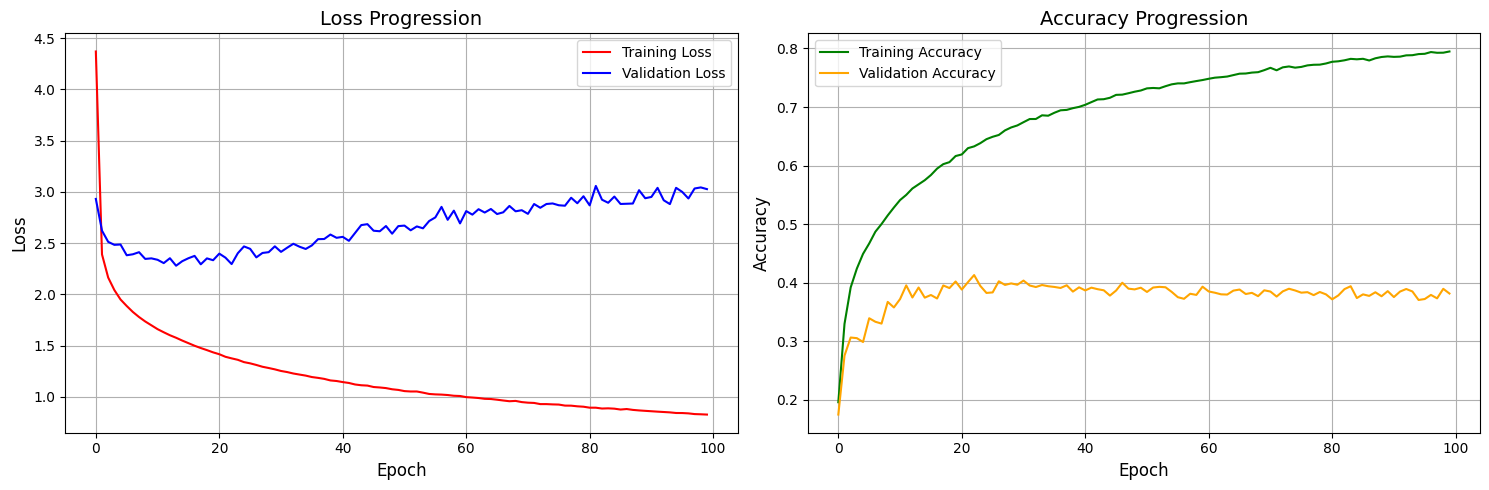

In [84]:
visualize(history, 'melspectrogram')

In [85]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

1331/1331 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8829 - loss: 0.5825 - weighted_accuracy: 0.8829
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3838 - loss: 3.0262 - weighted_accuracy: 0.3838


In [86]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.28      0.50      0.36       793
           1       0.47      0.57      0.52      1294
           2       0.51      0.49      0.50       617
           3       0.39      0.68      0.50       984
           4       0.08      0.06      0.07       229
           5       0.14      0.08      0.10       303
           6       0.18      0.17      0.18       275
           7       0.44      0.34      0.38       698
           8       0.17      0.40      0.24       176
           9       0.33      0.36      0.34       227
          10       0.32      0.33      0.32       455
          11       0.38      0.03      0.06      1660
          12       0.48      0.41      0.44      1261
          13       0.66      0.45      0.54       502
          14       0.05      0.10      0.06       156
          15       0.36      0.55      0.43       798
          16       0.53      0.68      0.60   

## Review all the results

In [87]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.996,0.347
4,melspectrogram,0.886,0.382
1,melspectrogram_chroma,0.890,0.376
2,melspectrogram_chroma_mfcc,0.901,0.373
3,mfcc_melspectrogram,0.877,0.396


In [88]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.331      0.839
4              melspectrogram     0.358      0.834
1       melspectrogram_chroma     0.357      0.830
2  melspectrogram_chroma_mfcc     0.340      0.824
3         mfcc_melspectrogram     0.366      0.823
